# Chapter6 再帰型ニューラルネットワーク（テキストデータの分類）　～映画レビューの感情分析プログラムを作る～
## 5. CNNを用いた感情分析

## 5.1. 前準備（パッケージのインポート）

In [ ]:
# 必要なパッケージのインストール
import numpy as np
import spacy
import matplotlib.pyplot as plt
import torch
from torchtext import data
from torchtext import datasets
from torch import nn
import torch.nn.functional as F
from torch import optim

## 5.2. 訓練データとテストデータの用意

In [ ]:
# Text, Label Fieldの定義
all_texts = data.Field(tokenize = 'spacy', batch_first = True)
all_labels = data.LabelField(dtype = torch.float)

In [ ]:
# データの取得
train_dataset, test_dataset = datasets.IMDB.splits(all_texts, all_labels)

print("train_dataset size: {}".format(len(train_dataset)))  # 訓練データのサイズ
print("test_dataset size: {}".format(len(test_dataset))) # テストデータのサイズ

aclImdb_v1.tar.gz:   0%|          | 180k/84.1M [00:00<00:54, 1.55MB/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 58.9MB/s]


train_dataset size: 25000
test_dataset size: 25000


In [ ]:
# 訓練データの中身の確認
print(vars(train_dataset.examples[0]))

{'text': ['The', 'Menagerie', 'parts', 'one', 'and', 'two', 'was', 'the', 'only', '2-parter', 'during', 'the', '3-year', 'run', 'of', 'the', 'original', 'Trek', 'series', 'and', 'it', 'was', 'because', 'Roddenberry', 'was', 'able', 'to', 'insert', 'most', 'of', 'the', 'footage', 'from', 'the', '1st', 'pilot', '"', 'The', 'Cage', '.', '"', 'The', 'move', 'was', 'made', 'out', 'of', 'necessity', ',', 'to', 'combat', 'deadline', 'problems', 'in', 'getting', 'episodes', 'produced', '(', 'such', 'a', 'sf', 'show', 'back', 'in', 'the', '1960s', 'was', 'a', 'hassle', 'to', 'get', 'done', 'on', 'time', ')', '.', 'One', 'positive', 'outcome', 'back', 'then', 'was', 'that', 'audiences', ',', 'unaware', 'of', 'the', 'pilot', 'produced', 'almost', 'a', 'couple', 'of', 'years', 'earlier', ',', 'were', 'treated', 'to', 'a', 'whole', 'new', 'crew', 'and', 'captain', 'for', 'these', 'two', 'episodes', 'on', 'top', 'of', 'the', 'regular', 'cast', 'of', 'characters', ',', 'as', 'if', 'the', 'producers',

In [ ]:
# Vocabularyの作成
max_vocab_size = 25_000

all_texts.build_vocab(train_dataset,
                      max_size = max_vocab_size,
                      vectors = 'glove.6B.100d',  # 学習済み単語埋め込みベクトル
                      unk_init = torch.Tensor.normal_)  # ランダムに初期化
all_labels.build_vocab(train_dataset)

print("Unique tokens in all_texts vocabulary: {}".format(len(all_texts.vocab)))
print("Unique tokens in all_labels vocabulary: {}".format(len(all_labels.vocab)))

.vector_cache/glove.6B.zip: 862MB [06:28, 2.22MB/s]                          
100%|█████████▉| 398077/400000 [00:15<00:00, 24931.91it/s]

Unique tokens in all_texts vocabulary: 25002
Unique tokens in all_labels vocabulary: 2


In [ ]:
# 上位20位の単語
print(all_texts.vocab.freqs.most_common(20))

[('the', 289838), (',', 275296), ('.', 236843), ('and', 156483), ('a', 156282), ('of', 144055), ('to', 133886), ('is', 109095), ('in', 87676), ('I', 77546), ('it', 76545), ('that', 70355), ('"', 63329), ("'s", 61928), ('this', 60483), ('-', 52863), ('/><br', 50935), ('was', 50013), ('as', 43508), ('with', 42807)]


In [ ]:
# テキストはID化されているがテキストに変換することもできる。
print(all_texts.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


In [ ]:
# labelの0と1がネガティブとポジティブどちらかを確認できる。
print(all_labels.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f8737558f28>, {'neg': 0, 'pos': 1})


In [ ]:
# ミニバッチの作成
batch_size = 64
# CPUとGPUどちらを使うかを指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# デバイスの確認
print("Device: {}".format(device))

train_batch, test_batch = data.BucketIterator.splits(
    (train_dataset, test_dataset),  # データセット
    batch_size = batch_size,  # バッチサイズ
    device = device)  # CPUかGPUかを指定

for batch in train_batch:
  print("text size: {}".format(batch.text[0].size()))  # テキストデータのサイズ
  print("squence size: {}".format(batch.text[1].size()))  # シーケンス長のサイズ
  print("label size: {}".format(batch.label.size()))  # ラベルデータのサイズ
  break

Device: cuda
text: tensor([[23792,     8,     2,  ...,     1,     1,     1],
        [ 1404,    11,   201,  ...,     1,     1,     1],
        [  318,    16,    24,  ...,     1,     1,     1],
        ...,
        [   11,    34,     6,  ...,     1,     1,     1],
        [  318,    11,   167,  ...,     1,     1,     1],
        [   11,   237,    16,  ...,     1,     1,     1]], device='cuda:0')
label: tensor([1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1.,
        1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
        0., 0., 1., 1., 1., 0., 1., 0., 0., 1.], device='cuda:0')


## 5.3. ニューラルネットワークの定義

In [ ]:
# ニューラルネットワークの定義
class Net(nn.Module):
    def __init__(self, D_in, D_embedding, n_kernels, kernel_size, D_out, dropout, pad_idx):
        super(Net, self).__init__()
        self.embedding = nn.Embedding(D_in, D_embedding, padding_idx = pad_idx)  # 単語埋め込み層
        
        # 畳み込み層
        self.conv0 = nn.Conv2d(in_channels = 1,  # 入力チャネル数
                                out_channels = n_kernels,  # 出力チャネル数(フィルタの数)  
                                kernel_size = (kernel_size[0], D_embedding))  # カーネルサイズ(フィルタサイズ)
        self.conv1 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_kernels, 
                                kernel_size = (kernel_size[1], D_embedding))
        self.conv2 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_kernels, 
                                kernel_size = (kernel_size[2], D_embedding))
        
        self.linear = nn.Linear(len(kernel_size) * n_kernels, D_out)  # 全結合層
        self.dropout = nn.Dropout(dropout)  # ドロップアウト層
        
    def forward(self, x):
        # 単語埋め込み
        embedded = self.embedding(x)  #text = [batch size, sent len], embedded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)  #embedded = [batch size, 1, sent len, emb dim]
        
        # 畳み込み
        conved0 = F.relu(self.conv0(embedded).squeeze(3))
        conved1 = F.relu(self.conv1(embedded).squeeze(3))
        conved2 = F.relu(self.conv2(embedded).squeeze(3))  #conved = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        # プーリング
        pooled0 = F.max_pool1d(conved0, conved0.shape[2]).squeeze(2)
        pooled1 = F.max_pool1d(conved1, conved1.shape[2]).squeeze(2)
        pooled2 = F.max_pool1d(conved2, conved2.shape[2]).squeeze(2)  #pooled = [batch size, n_filters]
        
        # プーリング層の出力を結合してドロップアウト層に入力
        cat = self.dropout(torch.cat((pooled0, pooled1, pooled2), dim = 1))
        # 全結合層
        output = self.linear(cat)  #cat = [batch size, n_filters * len(filter_sizes)]
        return output

In [ ]:
# ニューラルネットワークのロード
D_in = len(all_texts.vocab)  # 入力層の次元
D_embedding = 100  # 単語埋め込み層の次元
n_kernels = 100 # フィルタの数
kernel_size = [3, 4, 5]  # カーネルサイズ(フィルタサイズ)
D_out = 1  # 出力層の次元
dropout = 0.5  # ドロップアウトの確率
pad_idx = all_texts.vocab.stoi[all_texts.pad_token]  # <pad>トークンのインデックス

net = Net(D_in,
          D_embedding,
          n_kernels,
          kernel_size,
          D_out,
          dropout,
          pad_idx).to(device)
print(net)

Net(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (conv0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
  (conv1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
  (conv2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  (linear): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
# 学習済みの埋め込みを読み込み
pretrained_embeddings = all_texts.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([25002, 100])


In [ ]:
# 埋め込み層の重みを学習済みの埋め込みに置き換え
net.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-1.9052,  0.7877, -1.1334,  ...,  0.6563,  0.9350,  0.0020],
        [-0.1459, -0.3693,  0.4533,  ..., -0.7389, -0.9433, -0.0163],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 1.2805, -0.2297,  0.2668,  ..., -0.1469,  1.4328,  0.0323],
        [ 0.6127, -0.8021,  0.8675,  ...,  0.3333, -0.3998,  0.5386],
        [ 0.2996,  0.5626,  0.3728,  ..., -1.4322, -1.8758, -0.9653]],
       device='cuda:0')

In [ ]:
# 不明なトークン<unk>のインデックス取得
unk_idx = all_texts.vocab.stoi[all_texts.unk_token]

# <unk_idx>と<pad_idx>トークンのTensorをゼロで初期化
net.embedding.weight.data[unk_idx] = torch.zeros(D_embedding)
net.embedding.weight.data[pad_idx] = torch.zeros(D_embedding)

print(net.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 1.2805, -0.2297,  0.2668,  ..., -0.1469,  1.4328,  0.0323],
        [ 0.6127, -0.8021,  0.8675,  ...,  0.3333, -0.3998,  0.5386],
        [ 0.2996,  0.5626,  0.3728,  ..., -1.4322, -1.8758, -0.9653]],
       device='cuda:0')


## 5.4. 損失関数と最適化関数の定義

In [ ]:
# 損失関数の定義
criterion = nn.BCEWithLogitsLoss().to(device)

# 最適化関数の定義
optimizer = optim.Adam(net.parameters())

## 5.5. 学習

In [ ]:
# 損失と正解率を保存するリストを作成
train_loss_list = []  # 学習損失
train_accuracy_list = []  # 学習データの正答率
test_loss_list = []  # 評価損失
test_accuracy_list = []  # テストデータの正答率

# 学習（エポック）の実行
epoch = 10
for i in range(epoch):
    # エポックの進行状況を表示
    print('---------------------------------------------')
    print("Epoch: {}/{}".format(i+1, epoch))

    # 損失と正解率の初期化
    train_loss = 0  # 学習損失
    train_accuracy = 0  # 学習データの正答数
    test_loss = 0  # 評価損失
    test_accuracy = 0  # テストデータの正答数

    # ---------学習パート--------- #
    # ニューラルネットワークを学習モードに設定
    net.train()
    # ミニバッチごとにデータをロードし学習
    for batch in train_batch:
        # GPUにTensorを転送
        texts = batch.text
        labels = batch.label

        # 勾配を初期化
        optimizer.zero_grad()
        # データを入力して予測値を計算（順伝播）
        y_pred_prob = net(texts).squeeze(1)
        # 損失（誤差）を計算
        loss = criterion(y_pred_prob, labels)
        # 勾配の計算（逆伝搬）
        loss.backward()
        # パラメータ（重み）の更新
        optimizer.step()

        # ミニバッチごとの損失を蓄積
        train_loss += loss.item()

        # 予測したラベルを予測確率y_pred_probから計算
        y_pred_labels = torch.round(torch.sigmoid(y_pred_prob))
        # ミニバッチごとに正解したラベル数をカウント
        train_accuracy += torch.sum(y_pred_labels == labels).item()

    # エポックごとの損失と正解率を計算（ミニバッチの平均の損失と正解率を計算）
    epoch_train_loss = train_loss / len(train_batch.dataset)
    epoch_train_accuracy = train_accuracy / len(train_batch.dataset)
    # ---------学習パートはここまで--------- #

    # ---------評価パート--------- #
    # ニューラルネットワークを評価モードに設定
    net.eval()
    # 評価時の計算で自動微分機能をオフにする
    with torch.no_grad():
        for batch in test_batch:
            # GPUにTensorを転送
            texts = batch.text
            labels = batch.label
            # データを入力して予測値を計算（順伝播）
            y_pred_prob = net(texts).squeeze(1)
            # 損失（誤差）を計算
            loss = criterion(y_pred_prob, labels)
            # ミニバッチごとの損失を蓄積
            test_loss += loss.item()

            # 予測したラベルを予測確率y_pred_probから計算
            y_pred_labels = torch.round(torch.sigmoid(y_pred_prob))
            # ミニバッチごとに正解したラベル数をカウント
            test_accuracy += torch.sum(y_pred_labels == labels).item()
    # エポックごとの損失と正解率を計算（ミニバッチの平均の損失と正解率を計算）
    epoch_test_loss = test_loss / len(test_batch.dataset)
    epoch_test_accuracy = test_accuracy / len(test_batch.dataset)
    # ---------評価パートはここまで--------- #

    # エポックごとに損失と正解率を表示
    print("Train_Loss: {:.4f}, Train_Accuracy: {:.4f}".format(
        epoch_train_loss, epoch_train_accuracy))
    print("Test_Loss: {:.4f}, Test_Accuracy: {:.4f}".format(
        epoch_test_loss, epoch_test_accuracy))

    # 損失と正解率をリスト化して保存
    train_loss_list.append(epoch_train_loss)  # 学習損失
    train_accuracy_list.append(epoch_train_accuracy)  # 学習正答率
    test_loss_list.append(epoch_test_loss)  # テスト損失
    test_accuracy_list.append(epoch_test_accuracy)  # テスト正答率

---------------------------------------------
Epoch: 1/10


100%|█████████▉| 398077/400000 [00:30<00:00, 24931.91it/s]

Train_Loss: 0.0094, Train_Accuracy: 0.6637
Test_Loss: 0.0067, Test_Accuracy: 0.8026
---------------------------------------------
Epoch: 2/10
Train_Loss: 0.0056, Train_Accuracy: 0.8456
Test_Loss: 0.0051, Test_Accuracy: 0.8583
---------------------------------------------
Epoch: 3/10
Train_Loss: 0.0040, Train_Accuracy: 0.8964
Test_Loss: 0.0050, Test_Accuracy: 0.8643
---------------------------------------------
Epoch: 4/10
Train_Loss: 0.0029, Train_Accuracy: 0.9273
Test_Loss: 0.0051, Test_Accuracy: 0.8649
---------------------------------------------
Epoch: 5/10
Train_Loss: 0.0021, Train_Accuracy: 0.9496
Test_Loss: 0.0056, Test_Accuracy: 0.8620
---------------------------------------------
Epoch: 6/10
Train_Loss: 0.0015, Train_Accuracy: 0.9669
Test_Loss: 0.0061, Test_Accuracy: 0.8599
---------------------------------------------
Epoch: 7/10
Train_Loss: 0.0010, Train_Accuracy: 0.9782
Test_Loss: 0.0066, Test_Accuracy: 0.8638
---------------------------------------------
Epoch: 8/10
Train_

## 5.6. 結果の可視化

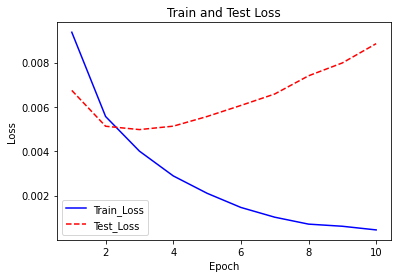

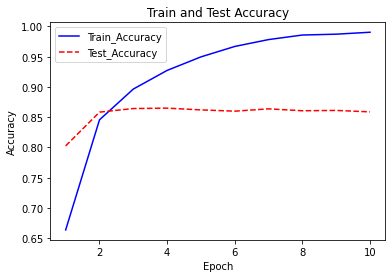

In [ ]:
# 損失
plt.figure()
plt.title('Train and Test Loss')  # タイトル
plt.xlabel('Epoch')  # 横軸名
plt.ylabel('Loss')  # 縦軸名
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')  # Train_lossのプロット
plt.plot(range(1, epoch+1), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')  # Test_lossのプロット
plt.legend()  # 凡例

# 正解率
plt.figure()
plt.title('Train and Test Accuracy')  # タイトル
plt.xlabel('Epoch')  # 横軸名
plt.ylabel('Accuracy')  # 縦軸名
plt.plot(range(1, epoch+1), train_accuracy_list, color='blue',
         linestyle='-', label='Train_Accuracy')  # Train_lossのプロット
plt.plot(range(1, epoch+1), test_accuracy_list, color='red',
         linestyle='--', label='Test_Accuracy')  # Test_lossのプロット
plt.legend()

# 表示
plt.show()

## 5.7. 新しいレビューに対する感情分析

In [ ]:
nlp = spacy.load('en')

def predict_sentiment(net, sentence, min_len = 5):
    net.eval()  # 評価モードに設定
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  # 文をトークン化して、リストに分割
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [all_texts.vocab.stoi[t] for t in tokenized]  # トークンにインデックスを付与
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)  # バッチの次元を追加。バッチの次元は1番目になるように設定
    prediction = torch.sigmoid(net(tensor))  # シグモイド関数で0から1の出力に
    return prediction

In [ ]:
y_pred_prob = predict_sentiment(net, "This film is terrible")
y_pred_label = torch.round(y_pred_prob)
print("Probability: {:.4f}".format(y_pred_prob.item()))
print("Pred Label: {:.0f}".format(y_pred_label.item()))

Probability: 0.037
Pred Label: 0


In [ ]:
y_pred_prob = predict_sentiment(net, "This film is great")
y_pred_label = torch.round(y_pred_prob)
print("Probability: {:.4f}".format(y_pred_prob.item()))
print("Pred Label: {:.0f}".format(y_pred_label.item()))

Probability: 0.991
Pred Label: 1
